<div align="center">

# Mona Lisa Problem

</div>

In [14]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [15]:
TRIANGLE = 3
SQUARE = 4
PENTAGON = 5
HEXAGON = 6

In [16]:
def add_polygon(base_img, x, y, d, angle, color_rgba, p):
    assert p > 2, "Polygon must have at least 3 vertices"

    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    points = []
    for i in range(p):
        ang = 2 * np.pi * i / p + angle
        px = x + d * np.cos(ang)
        py = y + d * np.sin(ang)
        points.append((px, py))

    draw.polygon(points, fill=tuple(color_rgba))
    return Image.alpha_composite(base_img, layer)

In [17]:
def render_image_from_individual(individual, width, height, p=TRIANGLE, background=(0, 0, 0, 255), with_alpha=True):
    base_img = Image.new("RGBA", (width, height), background)
    # draw = ImageDraw.Draw(base_img)
    for gene in individual:
        (x, y) = gene[0]
        d = gene[1]
        angle = gene[2]
        color = gene[3]  # [r,g,b,a]

        # points = []
        # for i in range(p):
        #     ang = 2 * np.pi * i / p + angle
        #     px = x + d * np.cos(ang)
        #     py = y + d * np.sin(ang)
        #     points.append((px, py))

        # draw.polygon(points, fill=tuple(color ))

        base_img = add_polygon(base_img, x, y, d, angle, color, p)

    return np.array(base_img.convert("RGB"))  # do fitness w RGB

In [18]:
def generate_individual(width, height, num_polygons=100, d_min=5, d_max=200, a_min=50, a_max=255):
    individual = []
    for _ in range(num_polygons):
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)
        distance = np.random.randint(d_min, d_max + 1)
        angle = np.random.uniform(0, 2 * np.pi)
        color = [
            np.random.randint(0, 256),   # r
            np.random.randint(0, 256),   # g
            np.random.randint(0, 256),   # b
            np.random.randint(a_min, a_max + 1)  # a
        ]
        individual.append([(x, y), distance, angle, color])
    return individual

In [19]:
def calculate_fitness_score(image1_rgb, image2_rgb):
    # oba powinny być RGB (H,W,3)
    diff = image1_rgb.astype(np.int64) - image2_rgb.astype(np.int64)
    return np.sum(diff * diff)

In [20]:
def create_population(n, t, im_height, im_width):
    return [generate_individual(im_width, im_height, t) for _ in range(n)]

In [21]:
def copy_individual(ind):
    # bezpieczna kopia: kopiuje listy wewnętrzne (x,y) i color
    new_ind = []
    for (xy, d, ang, col) in ind:
        new_ind.append([ (xy[0], xy[1]), int(d), float(ang), [int(col[0]), int(col[1]), int(col[2]), int(col[3])] ])
    return new_ind

In [22]:
def mutate(ind, t, im_height, im_width,
           pos_step=15, dist_step=15, ang_step=np.pi/8, col_step=15,
           d_min=5, d_max=200):
    idx = np.random.randint(0, t)
    gene = ind[idx]

    prob = np.random.rand()

    if prob < 0.25:
        # mutacja środka (x,y)
        x, y = gene[0]
        x = int(np.clip(x + np.random.randint(-pos_step, pos_step + 1), 0, im_width - 1))
        y = int(np.clip(y + np.random.randint(-pos_step, pos_step + 1), 0, im_height - 1))
        gene[0] = (x, y)

    elif prob < 0.5:
        # mutacja dystansu
        d = gene[1] + np.random.randint(-dist_step, dist_step + 1)
        gene[1] = int(np.clip(d, d_min, d_max))

    elif prob < 0.75:
        # mutacja kąta
        gene[2] = float(gene[2] + np.random.uniform(-ang_step, ang_step))

    else:
        # mutacja koloru (r,g,b,a)
        color = gene[3]
        c_idx = np.random.randint(0, 4)
        color[c_idx] = int(np.clip(color[c_idx] + np.random.randint(-col_step, col_step + 1), 0, 255))

In [23]:
def es_elitism(n, m, t, generations, original_image_rgb, p=TRIANGLE, vis_every=50):
    height, width, _ = original_image_rgb.shape
    per_parent_children = (n - m) // m

    population = create_population(n, t, height, width)
    fitness_scores = np.zeros(n, dtype=np.float64)

    for i in range(n):
        curr_im = render_image_from_individual(population[i], width, height, p=p)
        fitness_scores[i] = calculate_fitness_score(original_image_rgb, curr_im)
        print(f"Initial fitness score[{i}]: {fitness_scores[i]}")

    # wizualizacja setup
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ax_flat = axes.flatten()

    ax_flat[0].imshow(original_image_rgb)
    ax_flat[0].set_title("Original")
    ax_flat[0].axis("off")

    plt.close()

    for generation in range(generations):
        sorted_indices = np.argsort(fitness_scores)
        top_idx = sorted_indices[:m]          # elita: m najlepszych
        rest_idx = sorted_indices[m:]         # reszta (zastępowani)

        if generation % vis_every == 0:
            best = fitness_scores[top_idx[0]]
            for k in range(min(5, m)):
                idx = top_idx[k]
                img = render_image_from_individual(population[idx], width, height, p=p)
                ax_plot = ax_flat[k + 1]
                ax_plot.clear()
                ax_plot.imshow(img)
                ax_plot.set_title(f"Top {k+1} @ gen {generation}\nloss={best:.0f}" if k == 0 else f"Top {k+1} @ gen {generation}")
                ax_plot.axis("off")

            clear_output(wait=True)
            display(fig)

        # generowanie dzieci: elita produkuje potomków i nadpisuje najgorszych
        child_num = 0
        for parent_idx in top_idx:
            for _ in range(per_parent_children):
                if child_num >= len(rest_idx):
                    break
                target = rest_idx[child_num]

                population[target] = copy_individual(population[parent_idx])
                mutate(population[target], t, height, width)

                curr_im = render_image_from_individual(population[target], width, height, p=p)
                fitness_scores[target] = calculate_fitness_score(original_image_rgb, curr_im)

                child_num += 1

    best_idx = int(np.argmin(fitness_scores))
    return best_idx, population[best_idx], float(fitness_scores[best_idx])

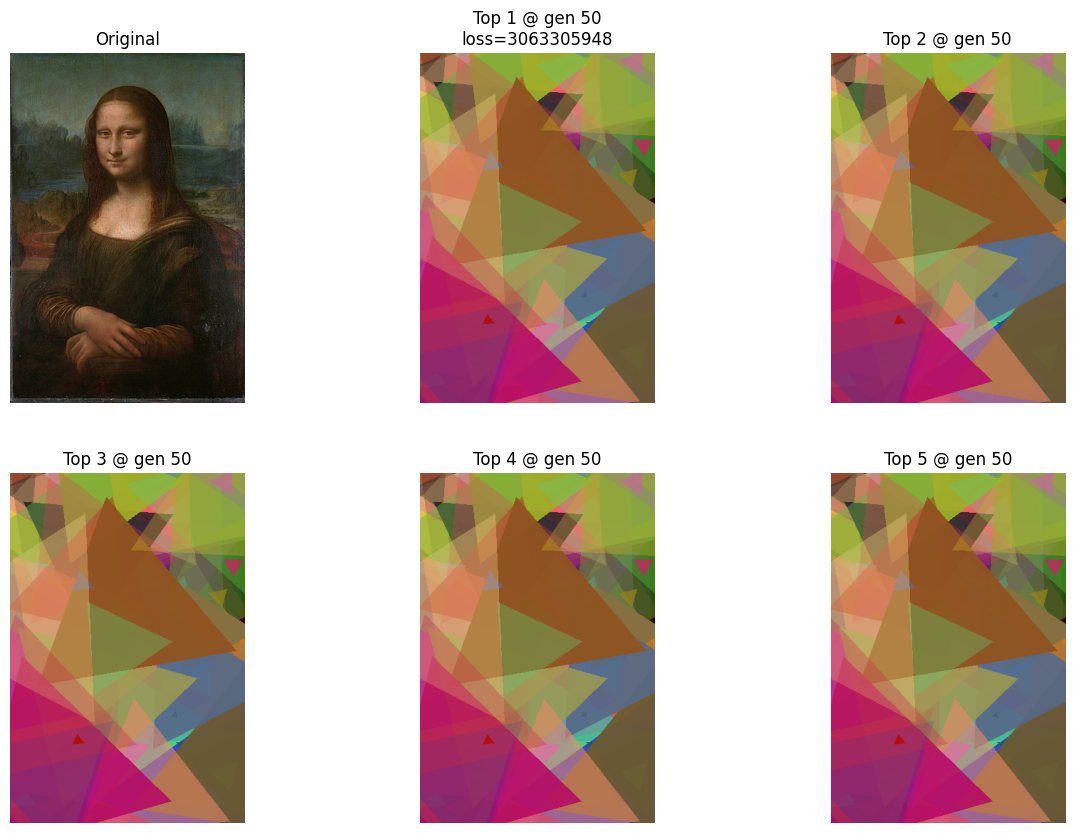

KeyboardInterrupt: 

In [24]:
image_path = "MonaLisaS.jpg"
original_rgb = np.array(Image.open(image_path).convert("RGB"))

N = 20
M = 5
T = 100
GENERATIONS = 100

best_idx, best_ind, best_loss = es_elitism(N, M, T, GENERATIONS, original_rgb, p=TRIANGLE, vis_every=50)

best_img = render_image_from_individual(best_ind, original_rgb.shape[1], original_rgb.shape[0], p=TRIANGLE)
plt.figure(figsize=(6,6))
plt.imshow(best_img)
plt.axis("off")
plt.title(f"Best loss: {best_loss:.0f}")
plt.show()


In [ ]:
import numpy as np
from PIL import Image, ImageDraw

def gene_to_points(gene, p):
    (x, y), d, angle, color = gene
    pts = []
    for i in range(p):
        ang = 2*np.pi*i/p + angle
        px = x + d*np.cos(ang)
        py = y + d*np.sin(ang)
        pts.append((px, py))
    return pts

def bbox_from_points(points, width, height, pad=2):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x0 = max(0, int(np.floor(min(xs) - pad)))
    y0 = max(0, int(np.floor(min(ys) - pad)))
    x1 = min(width,  int(np.ceil(max(xs) + pad)))
    y1 = min(height, int(np.ceil(max(ys) + pad)))
    if x1 <= x0 or y1 <= y0:
        return None
    return (x0, y0, x1, y1)

def sse_patch(a_rgb, b_rgb):
    diff = a_rgb.astype(np.int64) - b_rgb.astype(np.int64)
    return int(np.sum(diff * diff))

def apply_gene_rgba(base_rgba_img, gene, p):
    # szybkie dołożenie jednego wielokąta na kopii
    img = base_rgba_img.copy()
    img = add_polygon(img, gene[0][0], gene[0][1], gene[1], gene[2], gene[3], p)
    # draw = ImageDraw.Draw(img, "RGBA")
    # pts = gene_to_points(gene, p)
    # draw.polygon(pts, fill=tuple(gene[3]))
    return img

def mutate_gene(gene, width, height,
                step_xy=5, step_d=10, step_angle=0.2,
                step_rgb=15, step_a=15,
                d_min=5, d_max=200, a_min=50, a_max=255):
    (x, y), d, angle, color = gene
    r,g,b,a = color

    # losowo wybieramy jeden aspekt do zmiany (prosty neighborhood)
    choice = np.random.randint(0, 6)
    if choice == 0:
        x = int(np.clip(x + np.random.randint(-step_xy, step_xy+1), 0, width-1))
    elif choice == 1:
        y = int(np.clip(y + np.random.randint(-step_xy, step_xy+1), 0, height-1))
    elif choice == 2:
        d = int(np.clip(d + np.random.randint(-step_d, step_d+1), d_min, d_max))
    elif choice == 3:
        angle = float((angle + np.random.uniform(-step_angle, step_angle)) % (2*np.pi))
    elif choice == 4:
        r = int(np.clip(r + np.random.randint(-step_rgb, step_rgb+1), 0, 255))
        g = int(np.clip(g + np.random.randint(-step_rgb, step_rgb+1), 0, 255))
        b = int(np.clip(b + np.random.randint(-step_rgb, step_rgb+1), 0, 255))
    else:
        a = int(np.clip(a + np.random.randint(-step_a, step_a+1), a_min, a_max))

    return [(x, y), d, angle, [r,g,b,a]]

def optimize_gene_on_base(base_rgba_img, target_rgb, gene, p,
                          trials=200, patience=60):
    """
    Hill climb dla pojedynczego genu na ustalonej bazie.
    - trials: maksymalna liczba prób mutacji
    - patience: ile prób bez poprawy kończy optymalizację
    """
    width, height = base_rgba_img.size

    # aktualny obraz i fitness
    curr_img = apply_gene_rgba(base_rgba_img, gene, p).convert("RGB")
    curr_rgb = np.array(curr_img)
    best_loss = sse_patch(curr_rgb, target_rgb)

    no_improve = 0
    best_gene = gene

    for _ in range(trials):
        cand_gene = mutate_gene(best_gene, width, height)

        # Różnicowo: licz tylko patch w bbox wielokąta
        pts = gene_to_points(cand_gene, p)
        bb = bbox_from_points(pts, width, height, pad=2)
        if bb is None:
            no_improve += 1
            if no_improve >= patience:
                break
            continue
        x0,y0,x1,y1 = bb

        # render kandydata tylko do porównania - tu dla prostoty renderujemy cały,
        # ale liczmy SSE tylko na patchu (już sporo zysku).
        # Jeszcze szybciej byłoby renderować crop, ale to bardziej złożone w PIL.
        cand_img = apply_gene_rgba(base_rgba_img, cand_gene, p).convert("RGB")
        cand_rgb = np.array(cand_img)

        # SSE tylko na patchu
        cand_patch_loss = sse_patch(cand_rgb[y0:y1, x0:x1], target_rgb[y0:y1, x0:x1])
        curr_patch_loss = sse_patch(curr_rgb[y0:y1, x0:x1], target_rgb[y0:y1, x0:x1])
        cand_loss = best_loss - curr_patch_loss + cand_patch_loss

        if cand_loss < best_loss:
            best_loss = cand_loss
            best_gene = cand_gene
            curr_rgb = cand_rgb
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # zwracamy najlepszy gen i odpowiadający mu obraz RGB
    return best_gene, best_loss, curr_rgb

def constructive_hill_climb(target_rgb, width, height,
                            num_polygons=100, p=3,
                            background=(0,0,0,255),
                            gene_trials=300):
    base_rgba = Image.new("RGBA", (width, height), background)
    individual = []

    # start fitness dla samego tła
    base_rgb = np.array(base_rgba.convert("RGB"))
    base_loss = sse_patch(base_rgb, target_rgb)

    for i in range(num_polygons):
        # startowy gen losowy
        gene = generate_individual(width, height, num_polygons=1)[0]

        # optymalizuj gen na aktualnej bazie
        best_gene, best_loss, best_rgb = optimize_gene_on_base(
            base_rgba, target_rgb, gene, p, trials=gene_trials
        )

        # utrwal: dodaj gen do listy, zaktualizuj bazę (RGBA) już na stałe
        individual.append(best_gene)
        base_rgba = apply_gene_rgba(base_rgba, best_gene, p)

        # możesz logować postęp
        base_loss = best_loss
        # print(f"gene {i+1}/{num_polygons} loss={base_loss}")

    return individual, base_rgba

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


def hc_constructive_with_elite_viz(
    target_rgb: np.ndarray,
    num_polygons: int = 2000,
    p: int = 3,
    background=(0, 0, 0, 255),
    gene_trials: int = 250,
    vis_every: int = 100,
):
    """
    Konstrukcyjny hill climbing:
    - dokładamy gen po genie
    - każdy gen optymalizujemy lokalnie (hill climb) na aktualnej bazie
    - wizualizacja 2x3: Original + 5 najlepszych wyników dotychczas (hall of fame)
    """
    height, width, _ = target_rgb.shape

    # baza startowa
    base_rgba = Image.new("RGBA", (width, height), background)
    base_rgb = np.array(base_rgba.convert("RGB"))
    best_loss = float(calculate_fitness_score(target_rgb, base_rgb))

    # hall of fame: lista (loss, img_rgb_np)
    # trzymamy do 5 najlepszych znalezionych obrazów
    hof = [(best_loss, base_rgb.copy())]

    # setup wizualizacji 2x3
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ax_flat = axes.flatten()

    ax_flat[0].imshow(target_rgb)
    ax_flat[0].set_title("Original")
    ax_flat[0].axis("off")

    plt.close()  # jak u Ciebie - nie renderuj od razu

    def update_hof(loss_val: float, img_rgb: np.ndarray):
        nonlocal hof
        hof.append((loss_val, img_rgb.copy()))
        hof.sort(key=lambda x: x[0])     # rosnąco po loss
        # usuń duplikaty "prawie identycznych" lossów (opcjonalnie)
        # tutaj prosto: zostaw top 5
        hof = hof[:5]

    for gen in range(1, num_polygons + 1):
        # startowy gen losowy
        gene = generate_individual(width, height, num_polygons=1)[0]

        # optymalizacja genu na aktualnej bazie
        best_gene, cand_loss, cand_rgb = optimize_gene_on_base(
            base_rgba,
            target_rgb,
            gene,
            p,
            trials=gene_trials,
            patience=max(30, gene_trials // 3),
        )

        # utrwalamy gen (zawsze dokładamy kolejny)
        base_rgba = apply_gene_rgba(base_rgba, best_gene, p)

        # loss po utrwaleniu jest cand_loss (z optimize_gene_on_base)
        best_loss = float(cand_loss)

        # aktualizuj hall of fame, jeśli to jeden z top wyników
        # (tu dodajemy zawsze, potem ucinamy do top5)
        update_hof(best_loss, np.array(base_rgba.convert("RGB")))

        # wizualizacja co vis_every
        if gen % vis_every == 0:
            # wyczyść sloty 1..5 i wstaw topy z hof
            for k in range(5):
                axp = ax_flat[k + 1]
                axp.clear()
                if k < len(hof):
                    loss_k, img_k = hof[k]
                    axp.imshow(img_k)
                    if k == 0:
                        axp.set_title(f"Top 1 @ gen {gen}\nloss={loss_k:.0f}")
                    else:
                        axp.set_title(f"Top {k+1} @ gen {gen}")
                else:
                    axp.set_title(f"Top {k+1} @ gen {gen}")
                axp.axis("off")

            clear_output(wait=True)
            display(fig)

    # wynik końcowy: najlepszy z hof (top 1)
    best_final_loss, best_final_img = hof[0]
    return best_final_img, best_final_loss, base_rgba


In [ ]:
image_path = "MonaLisaS.jpg"
original_rgb = np.array(Image.open(image_path).convert("RGB"))

# target_rgb = np.array(Image.open("mona_lisa.jpg").convert("RGB"))
best_img, best_loss, final_rgba = hc_constructive_with_elite_viz(
    target_rgb=original_rgb,  # u Ciebie już jest w RGB
    num_polygons=2000,
    p=PENTAGON,
    gene_trials=10000,
    vis_every=10,
)
print("Best loss:", best_loss)


KeyboardInterrupt: 

In [ ]:
image_path = "MonaLisaS.jpg"
original_rgb = np.array(Image.open(image_path).convert("RGB"))

N = 20
M = 5
T = 80
GENERATIONS = 100000

best_idx, best_ind, best_loss = es_elitism(N, M, T, GENERATIONS, original_rgb, p=SQUARE, vis_every=50)

best_img = render_image_from_individual(best_ind, original_rgb.shape[1], original_rgb.shape[0], p=SQUARE)
plt.figure(figsize=(6,6))
plt.imshow(best_img)
plt.axis("off")
plt.title(f"Best loss: {best_loss:.0f}")
plt.show()